# Add a title here :P

https://www.sqlitetutorial.net/sqlite-sample-database/


https://www.chrisnicoll.net/2020/02/exploring-an-sqlite-database-from-jupyter-notebook/


https://www.sqlite.org/pragma.html



<br>
<br>
from: https://docs.yugabyte.com/latest/sample-data/chinook/

About the Chinook database

The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers.

    Media-related data was created using real data from an Apple iTunes library.
    Customer and employee information was created using fictitious names and addresses that can be located on Google maps, and other well formatted data (phone, fax, email, etc.)
    Sales information was auto generated using random data for a four year period.

The Chinook sample database includes:

    11 tables
    A variety of indexes, primary and foreign key constraints
    Over 15,000 rows of data

For details, here's the entity relationship diagram of the Chinook data model.
(Add image of the db schema here)

***

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('chinook.db')
cur = conn.cursor()

 from invoice table, can I get employee who closed the sale?
    invoice table > dates: how many years of sales do I have in this db?

from media_type, what is the most popular media? (i.e. best seller)

from genres, what is the most popular media? (i.e. best seller)

In [3]:
# How many invoices does the db have?
cur.execute("""
SELECT COUNT(*)
FROM Invoices
""")
info = cur.fetchall()
print(*info, sep='\n')  

(412,)


In [4]:
query = ("""
SELECT *
FROM Invoices
""")

invoices_df = pd.read_sql(query, conn)
invoices_df.head()

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86


In [5]:
invoices_df['Year'] = pd.DatetimeIndex(invoices_df['InvoiceDate']).year
invoices_df['Month'] = pd.DatetimeIndex(invoices_df['InvoiceDate']).month
invoices_df.head()

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total,Year,Month
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98,2009,1
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96,2009,1
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94,2009,1
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91,2009,1
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86,2009,1


In [6]:
# The db contains information for several years, let's see which ones and how many:
invoices_df['Year'].value_counts()

2009    83
2010    83
2011    83
2012    83
2013    80
Name: Year, dtype: int64

In [60]:
### Let's see how much was sold per month and year:
# create sub_df
total_sales_raw = invoices_df[['Month', 'Year', 'Total']]
# groupby and create pivot table
total_sales = total_sales_raw.groupby(['Month', 'Year'], as_index=False)['Total'].sum() # as_index=False is necessary to get a DataFrame instead of a Series
total_sales_table = total_sales.pivot(index='Month', columns='Year', values='Total')
total_sales_table

Year,2009,2010,2011,2012,2013
Month,,,,,
1,35.64,52.62,37.62,37.62,37.62
2,37.62,46.62,37.62,37.62,27.72
3,37.62,44.62,37.62,37.62,37.62
4,37.62,37.62,51.62,37.62,33.66
5,37.62,37.62,42.62,37.62,37.62
6,37.62,37.62,50.62,37.62,37.62
7,37.62,37.62,37.62,39.62,37.62
8,37.62,37.62,37.62,47.62,37.62
9,37.62,36.63,37.62,46.71,37.62


In [38]:
### plot sales per month
# how many invoices per month are there in the db? (this will combine months from different years)
query = ("""
SELECT strftime('%m', InvoiceDate) AS Month, COUNT(strftime('%m', InvoiceDate)) as Count
    FROM Invoices
        GROUP BY strftime('%m', InvoiceDate)
""")
# what is the total amount sold per month for year=2009?
query2009 = ("""
SELECT strftime('%m', InvoiceDate) AS Month, SUM(Total) as Total
    FROM Invoices
        GROUP BY strftime('%m', InvoiceDate)
        HAVING strftime('%Y', InvoiceDate) = 2009
""")
# what is the total amount sold per month for year=2010?
query2010 = ("""
SELECT strftime('%m', InvoiceDate) AS Month, SUM(Total) as Total
    FROM Invoices
        GROUP BY strftime('%m', InvoiceDate)
        HAVING strftime('%Y', InvoiceDate) = 2010
""")
# what is the total amount sold per month for year=2011?
query2011 = ("""
SELECT strftime('%m', InvoiceDate) AS Month, SUM(Total) as Total
    FROM Invoices
        GROUP BY strftime('%m', InvoiceDate)
        HAVING strftime('%Y', InvoiceDate) = 2011
""")
# what is the total amount sold per month for year=2012?   >>>>>>>>>>>>> HAVING
query2012 = ("""
SELECT strftime('%m', InvoiceDate) AS Month, SUM(Total) as Total
    FROM Invoices
        GROUP BY strftime('%m', InvoiceDate)
        HAVING strftime('%Y', InvoiceDate) = 2012
""")
# what is the total amount sold per month for year=2013?   >>>>>>>>>>>>> WHERE
query2013 = ("""
SELECT strftime('%m', InvoiceDate) AS Month, strftime('%Y', InvoiceDate) AS Year, SUM(Total) as Total
    FROM Invoices
        WHERE strftime('%Y', InvoiceDate) = 2013
        GROUP BY strftime('%m', InvoiceDate)
""")

transactions_per_month = pd.read_sql(query, conn)
total_per_month_2009 = pd.read_sql(query2009, conn)
total_per_month_2010 = pd.read_sql(query2010, conn)
total_per_month_2011 = pd.read_sql(query2011, conn)
total_per_month_2012 = pd.read_sql(query2012, conn)
total_per_month_2013 = pd.read_sql(query2013, conn)

total_per_month_2013  # NOT WORKING!!!!!!!!!!!!!
# total_m_sales = transactions_per_month.merge(total_per_month, how='left', on='Month')
# total_m_sales.set_index('Month', inplace=True)
# total_m_sales

,Month,Year,Total


In [8]:
### plot sales per year
# how many invoices per year are there in the db?
query = ("""
SELECT strftime('%Y', InvoiceDate) AS Year, COUNT(strftime('%Y', InvoiceDate)) as Count
FROM Invoices
GROUP BY strftime('%Y', InvoiceDate)
""")
# what is the total amount sold per year?
query2 = ("""
SELECT strftime('%Y', InvoiceDate) AS Year, SUM(Total) as Total
FROM Invoices
GROUP BY strftime('%Y', InvoiceDate)
""")

transactions_per_year = pd.read_sql(query, conn)
total_per_year = pd.read_sql(query2, conn)

total_y_sales = sales_per_year.merge(total_per_year, how='left', on='Year')
total_y_sales.set_index('Year', inplace=True)
total_y_sales # THIS IS TOO LOW! CHECK!!!

,Count,Total
Year,,
2009,83,449.46
2010,83,481.45
2011,83,469.58
2012,83,477.53
2013,80,450.58


[(400.0, 500.0)]

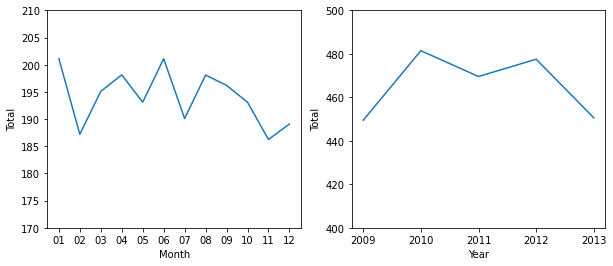

In [9]:
fig, axs = plt.subplots(ncols=2)
# fig = plt.gcf()
fig.set_size_inches(10, 4) # change plot size

ax1 = sns.lineplot(data=total_m_sales, x='Month', y='Total', ax=axs[0])
ax1.set(ylim=(170, 210))
ax2 = sns.lineplot(data=total_y_sales, x='Year', y='Total', ax=axs[1])
ax2.set(ylim=(400, 500))

Is there a 'high season' for this store? Christmas, Valentine's, etc? NO

We can see that sales fluctuate month to month, but I wouldn't say there's a high season, because the range min-max is just 15...

Again, we can see that sales fluctuate year to year, but not that much, because the range min-max is just 35...

@@@@@@@@@@@@@@@ EDIT THIS!!!

***

In [11]:
# Exploring Invoice_items table:

query = """
SELECT *
FROM Invoice_items
"""

invoice_items = pd.read_sql(query, conn)
invoice_items.head()

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1


In [15]:
invoice_items.rename(columns={'InvoiceLineId': 'InvoiceItemId'}, inplace=True)
invoice_items.head()

,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1


In [16]:
invoice_items['UnitPrice'].value_counts() # there are only 2 prices for the different tracks, $0.99 and $1.99

0.99    2129
1.99     111
Name: UnitPrice, dtype: int64

In [17]:
# which songs are priced 1.99?
query = """
SELECT AR.ArtistId, AR.Name AS ArtistName, AL.AlbumId, AL.Title AS AlbumTitle, AL.ArtistId, T.TrackId, T.Name AS TrackName, T.AlbumId, T.GenreId, G.GenreId, G.Name AS GenreName
    FROM Artists AR
        INNER JOIN Albums AL ON AR.ArtistId = AL.ArtistId
        INNER JOIN Genres G ON G.GenreId = T.GenreId
        INNER JOIN Tracks T ON AL.AlbumId = T.AlbumId AND T.UnitPrice == 1.99
"""

tracks_2 = pd.read_sql(query, conn)
tracks_2.head()

,ArtistId,ArtistName,AlbumId,AlbumTitle,ArtistId,TrackId,TrackName,AlbumId,GenreId,GenreId,GenreName
0,147,Battlestar Galactica,226,Battlestar Galactica: The Story So Far,147,2819,Battlestar Galactica: The Story So Far,226,18,18,Science Fiction
1,147,Battlestar Galactica,227,"Battlestar Galactica, Season 3",147,2820,Occupation / Precipice,227,19,19,TV Shows
2,147,Battlestar Galactica,227,"Battlestar Galactica, Season 3",147,2821,"Exodus, Pt. 1",227,19,19,TV Shows
3,147,Battlestar Galactica,227,"Battlestar Galactica, Season 3",147,2822,"Exodus, Pt. 2",227,19,19,TV Shows
4,147,Battlestar Galactica,227,"Battlestar Galactica, Season 3",147,2823,Collaborators,227,19,19,TV Shows


In [18]:
tracks_2dollars = tracks_2[['ArtistName', 'AlbumTitle', 'TrackName', 'GenreName']]
tracks_2dollars.head()

,ArtistName,AlbumTitle,TrackName,GenreName
0,Battlestar Galactica,Battlestar Galactica: The Story So Far,Battlestar Galactica: The Story So Far,Science Fiction
1,Battlestar Galactica,"Battlestar Galactica, Season 3",Occupation / Precipice,TV Shows
2,Battlestar Galactica,"Battlestar Galactica, Season 3","Exodus, Pt. 1",TV Shows
3,Battlestar Galactica,"Battlestar Galactica, Season 3","Exodus, Pt. 2",TV Shows
4,Battlestar Galactica,"Battlestar Galactica, Season 3",Collaborators,TV Shows


In [19]:
tracks_2dollars['GenreName'].value_counts() # these are the more expensive genres

TV Shows            93
Drama               64
Sci Fi & Fantasy    26
Comedy              17
Science Fiction     13
Name: GenreName, dtype: int64

In [20]:
# which songs are priced 0.99?
query = """
SELECT AR.ArtistId, AR.Name AS ArtistName, AL.AlbumId, AL.Title AS AlbumTitle, AL.ArtistId, T.TrackId, T.Name AS TrackName, T.AlbumId, T.GenreId, G.GenreId, G.Name AS GenreName
    FROM Artists AR
        INNER JOIN Albums AL ON AR.ArtistId = AL.ArtistId
        INNER JOIN Genres G ON G.GenreId = T.GenreId
        INNER JOIN Tracks T ON AL.AlbumId = T.AlbumId AND T.UnitPrice == 0.99
"""

tracks_1 = pd.read_sql(query, conn)
tracks_1.head()

,ArtistId,ArtistName,AlbumId,AlbumTitle,ArtistId,TrackId,TrackName,AlbumId,GenreId,GenreId,GenreName
0,1,AC/DC,1,For Those About To Rock We Salute You,1,1,For Those About To Rock (We Salute You),1,1,1,Rock
1,2,Accept,2,Balls to the Wall,2,2,Balls to the Wall,2,1,1,Rock
2,2,Accept,3,Restless and Wild,2,3,Fast As a Shark,3,1,1,Rock
3,2,Accept,3,Restless and Wild,2,4,Restless and Wild,3,1,1,Rock
4,2,Accept,3,Restless and Wild,2,5,Princess of the Dawn,3,1,1,Rock


In [21]:
tracks_1dollar = tracks_1[['ArtistName', 'AlbumTitle', 'TrackName', 'GenreName']]
tracks_1dollar['GenreName'].value_counts() # these are the less expensive genres

Rock                  1297
Latin                  579
Metal                  374
Alternative & Punk     332
Jazz                   130
Blues                   81
Classical               74
R&B/Soul                61
Reggae                  58
Pop                     48
Soundtrack              43
Alternative             40
Hip Hop/Rap             35
Electronica/Dance       30
World                   28
Heavy Metal             28
Easy Listening          24
Bossa Nova              15
Rock And Roll           12
Opera                    1
Name: GenreName, dtype: int64

In [22]:
query = """
SELECT *
    FROM Genres
"""

genres = pd.read_sql(query, conn)
genres['Name'].values

array(['Rock', 'Jazz', 'Metal', 'Alternative & Punk', 'Rock And Roll',
       'Blues', 'Latin', 'Reggae', 'Pop', 'Soundtrack', 'Bossa Nova',
       'Easy Listening', 'Heavy Metal', 'R&B/Soul', 'Electronica/Dance',
       'World', 'Hip Hop/Rap', 'Science Fiction', 'TV Shows',
       'Sci Fi & Fantasy', 'Drama', 'Comedy', 'Alternative', 'Classical',
       'Opera'], dtype=object)

In [23]:
genres.shape

(25, 2)

So, price depends on genre, and all genres associated with the TV/film industry are more expensive than the rest, purely musical genres.

***

In [24]:
query = """
SELECT DISTINCT(TrackId)
FROM Invoice_items
"""
unique_tracks = pd.read_sql(query, conn)
len(unique_tracks) # 1984 

query2 = """
SELECT TrackId, COUNT(TrackId) as Count
    FROM Invoice_items
    GROUP BY TrackId
    ORDER BY Count DESC
"""

popular_tracks = pd.read_sql(query2, conn)
popular_tracks.head(10)

,TrackId,Count
0,2,2
1,8,2
2,9,2
3,20,2
4,32,2
5,48,2
6,66,2
7,84,2
8,161,2
9,162,2


If the top 10 most sold tracks sold just 2, sales is not a good thing to explore here! ,:)

It seems that most tracks were sold by unit

In [ ]:
# Find the names of those top ten tracks

In [25]:
# I want to find all tracks that were purchased together (maybe it's an album?)
# I need to find all TrackId with the same InvoiceId

grouped_df = invoice_items.groupby(['InvoiceId']).apply(display) # this gives me ALL INVOICES

,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1
5,6,2,12,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
6,7,3,16,0.99,1
7,8,3,20,0.99,1
8,9,3,24,0.99,1
9,10,3,28,0.99,1
10,11,3,32,0.99,1
11,12,3,36,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
12,13,4,42,0.99,1
13,14,4,48,0.99,1
14,15,4,54,0.99,1
15,16,4,60,0.99,1
16,17,4,66,0.99,1
17,18,4,72,0.99,1
18,19,4,78,0.99,1
19,20,4,84,0.99,1
20,21,4,90,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
21,22,5,99,0.99,1
22,23,5,108,0.99,1
23,24,5,117,0.99,1
24,25,5,126,0.99,1
25,26,5,135,0.99,1
26,27,5,144,0.99,1
27,28,5,153,0.99,1
28,29,5,162,0.99,1
29,30,5,171,0.99,1
30,31,5,180,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
35,36,6,230,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
36,37,7,231,0.99,1
37,38,7,232,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
38,39,8,234,0.99,1
39,40,8,236,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
40,41,9,238,0.99,1
41,42,9,240,0.99,1
42,43,9,242,0.99,1
43,44,9,244,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
44,45,10,248,0.99,1
45,46,10,252,0.99,1
46,47,10,256,0.99,1
47,48,10,260,0.99,1
48,49,10,264,0.99,1
49,50,10,268,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
50,51,11,274,0.99,1
51,52,11,280,0.99,1
52,53,11,286,0.99,1
53,54,11,292,0.99,1
54,55,11,298,0.99,1
55,56,11,304,0.99,1
56,57,11,310,0.99,1
57,58,11,316,0.99,1
58,59,11,322,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
59,60,12,331,0.99,1
60,61,12,340,0.99,1
61,62,12,349,0.99,1
62,63,12,358,0.99,1
63,64,12,367,0.99,1
64,65,12,376,0.99,1
65,66,12,385,0.99,1
66,67,12,394,0.99,1
67,68,12,403,0.99,1
68,69,12,412,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
73,74,13,462,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
74,75,14,463,0.99,1
75,76,14,464,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
76,77,15,466,0.99,1
77,78,15,468,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
78,79,16,470,0.99,1
79,80,16,472,0.99,1
80,81,16,474,0.99,1
81,82,16,476,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
82,83,17,480,0.99,1
83,84,17,484,0.99,1
84,85,17,488,0.99,1
85,86,17,492,0.99,1
86,87,17,496,0.99,1
87,88,17,500,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
88,89,18,506,0.99,1
89,90,18,512,0.99,1
90,91,18,518,0.99,1
91,92,18,524,0.99,1
92,93,18,530,0.99,1
93,94,18,536,0.99,1
94,95,18,542,0.99,1
95,96,18,548,0.99,1
96,97,18,554,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
97,98,19,563,0.99,1
98,99,19,572,0.99,1
99,100,19,581,0.99,1
100,101,19,590,0.99,1
101,102,19,599,0.99,1
102,103,19,608,0.99,1
103,104,19,617,0.99,1
104,105,19,626,0.99,1
105,106,19,635,0.99,1
106,107,19,644,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
111,112,20,694,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
112,113,21,695,0.99,1
113,114,21,696,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
114,115,22,698,0.99,1
115,116,22,700,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
116,117,23,702,0.99,1
117,118,23,704,0.99,1
118,119,23,706,0.99,1
119,120,23,708,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
120,121,24,712,0.99,1
121,122,24,716,0.99,1
122,123,24,720,0.99,1
123,124,24,724,0.99,1
124,125,24,728,0.99,1
125,126,24,732,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
126,127,25,738,0.99,1
127,128,25,744,0.99,1
128,129,25,750,0.99,1
129,130,25,756,0.99,1
130,131,25,762,0.99,1
131,132,25,768,0.99,1
132,133,25,774,0.99,1
133,134,25,780,0.99,1
134,135,25,786,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
135,136,26,795,0.99,1
136,137,26,804,0.99,1
137,138,26,813,0.99,1
138,139,26,822,0.99,1
139,140,26,831,0.99,1
140,141,26,840,0.99,1
141,142,26,849,0.99,1
142,143,26,858,0.99,1
143,144,26,867,0.99,1
144,145,26,876,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
149,150,27,926,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
150,151,28,927,0.99,1
151,152,28,928,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
152,153,29,930,0.99,1
153,154,29,932,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
154,155,30,934,0.99,1
155,156,30,936,0.99,1
156,157,30,938,0.99,1
157,158,30,940,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
158,159,31,944,0.99,1
159,160,31,948,0.99,1
160,161,31,952,0.99,1
161,162,31,956,0.99,1
162,163,31,960,0.99,1
163,164,31,964,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
164,165,32,970,0.99,1
165,166,32,976,0.99,1
166,167,32,982,0.99,1
167,168,32,988,0.99,1
168,169,32,994,0.99,1
169,170,32,1000,0.99,1
170,171,32,1006,0.99,1
171,172,32,1012,0.99,1
172,173,32,1018,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
173,174,33,1027,0.99,1
174,175,33,1036,0.99,1
175,176,33,1045,0.99,1
176,177,33,1054,0.99,1
177,178,33,1063,0.99,1
178,179,33,1072,0.99,1
179,180,33,1081,0.99,1
180,181,33,1090,0.99,1
181,182,33,1099,0.99,1
182,183,33,1108,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
187,188,34,1158,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
188,189,35,1159,0.99,1
189,190,35,1160,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
190,191,36,1162,0.99,1
191,192,36,1164,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
192,193,37,1166,0.99,1
193,194,37,1168,0.99,1
194,195,37,1170,0.99,1
195,196,37,1172,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
196,197,38,1176,0.99,1
197,198,38,1180,0.99,1
198,199,38,1184,0.99,1
199,200,38,1188,0.99,1
200,201,38,1192,0.99,1
201,202,38,1196,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
202,203,39,1202,0.99,1
203,204,39,1208,0.99,1
204,205,39,1214,0.99,1
205,206,39,1220,0.99,1
206,207,39,1226,0.99,1
207,208,39,1232,0.99,1
208,209,39,1238,0.99,1
209,210,39,1244,0.99,1
210,211,39,1250,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
211,212,40,1259,0.99,1
212,213,40,1268,0.99,1
213,214,40,1277,0.99,1
214,215,40,1286,0.99,1
215,216,40,1295,0.99,1
216,217,40,1304,0.99,1
217,218,40,1313,0.99,1
218,219,40,1322,0.99,1
219,220,40,1331,0.99,1
220,221,40,1340,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
225,226,41,1390,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
226,227,42,1391,0.99,1
227,228,42,1392,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
228,229,43,1394,0.99,1
229,230,43,1396,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
230,231,44,1398,0.99,1
231,232,44,1400,0.99,1
232,233,44,1402,0.99,1
233,234,44,1404,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
234,235,45,1408,0.99,1
235,236,45,1412,0.99,1
236,237,45,1416,0.99,1
237,238,45,1420,0.99,1
238,239,45,1424,0.99,1
239,240,45,1428,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
240,241,46,1434,0.99,1
241,242,46,1440,0.99,1
242,243,46,1446,0.99,1
243,244,46,1452,0.99,1
244,245,46,1458,0.99,1
245,246,46,1464,0.99,1
246,247,46,1470,0.99,1
247,248,46,1476,0.99,1
248,249,46,1482,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
249,250,47,1491,0.99,1
250,251,47,1500,0.99,1
251,252,47,1509,0.99,1
252,253,47,1518,0.99,1
253,254,47,1527,0.99,1
254,255,47,1536,0.99,1
255,256,47,1545,0.99,1
256,257,47,1554,0.99,1
257,258,47,1563,0.99,1
258,259,47,1572,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
263,264,48,1622,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
264,265,49,1623,0.99,1
265,266,49,1624,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
266,267,50,1626,0.99,1
267,268,50,1628,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
268,269,51,1630,0.99,1
269,270,51,1632,0.99,1
270,271,51,1634,0.99,1
271,272,51,1636,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
272,273,52,1640,0.99,1
273,274,52,1644,0.99,1
274,275,52,1648,0.99,1
275,276,52,1652,0.99,1
276,277,52,1656,0.99,1
277,278,52,1660,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
278,279,53,1666,0.99,1
279,280,53,1672,0.99,1
280,281,53,1678,0.99,1
281,282,53,1684,0.99,1
282,283,53,1690,0.99,1
283,284,53,1696,0.99,1
284,285,53,1702,0.99,1
285,286,53,1708,0.99,1
286,287,53,1714,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
287,288,54,1723,0.99,1
288,289,54,1732,0.99,1
289,290,54,1741,0.99,1
290,291,54,1750,0.99,1
291,292,54,1759,0.99,1
292,293,54,1768,0.99,1
293,294,54,1777,0.99,1
294,295,54,1786,0.99,1
295,296,54,1795,0.99,1
296,297,54,1804,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
301,302,55,1854,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
302,303,56,1855,0.99,1
303,304,56,1856,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
304,305,57,1858,0.99,1
305,306,57,1860,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
306,307,58,1862,0.99,1
307,308,58,1864,0.99,1
308,309,58,1866,0.99,1
309,310,58,1868,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
310,311,59,1872,0.99,1
311,312,59,1876,0.99,1
312,313,59,1880,0.99,1
313,314,59,1884,0.99,1
314,315,59,1888,0.99,1
315,316,59,1892,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
316,317,60,1898,0.99,1
317,318,60,1904,0.99,1
318,319,60,1910,0.99,1
319,320,60,1916,0.99,1
320,321,60,1922,0.99,1
321,322,60,1928,0.99,1
322,323,60,1934,0.99,1
323,324,60,1940,0.99,1
324,325,60,1946,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
325,326,61,1955,0.99,1
326,327,61,1964,0.99,1
327,328,61,1973,0.99,1
328,329,61,1982,0.99,1
329,330,61,1991,0.99,1
330,331,61,2000,0.99,1
331,332,61,2009,0.99,1
332,333,61,2018,0.99,1
333,334,61,2027,0.99,1
334,335,61,2036,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
339,340,62,2086,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
340,341,63,2087,0.99,1
341,342,63,2088,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
342,343,64,2090,0.99,1
343,344,64,2092,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
344,345,65,2094,0.99,1
345,346,65,2096,0.99,1
346,347,65,2098,0.99,1
347,348,65,2100,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
348,349,66,2104,0.99,1
349,350,66,2108,0.99,1
350,351,66,2112,0.99,1
351,352,66,2116,0.99,1
352,353,66,2120,0.99,1
353,354,66,2124,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
354,355,67,2130,0.99,1
355,356,67,2136,0.99,1
356,357,67,2142,0.99,1
357,358,67,2148,0.99,1
358,359,67,2154,0.99,1
359,360,67,2160,0.99,1
360,361,67,2166,0.99,1
361,362,67,2172,0.99,1
362,363,67,2178,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
363,364,68,2187,0.99,1
364,365,68,2196,0.99,1
365,366,68,2205,0.99,1
366,367,68,2214,0.99,1
367,368,68,2223,0.99,1
368,369,68,2232,0.99,1
369,370,68,2241,0.99,1
370,371,68,2250,0.99,1
371,372,68,2259,0.99,1
372,373,68,2268,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
377,378,69,2318,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
378,379,70,2319,0.99,1
379,380,70,2320,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
380,381,71,2322,0.99,1
381,382,71,2324,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
382,383,72,2326,0.99,1
383,384,72,2328,0.99,1
384,385,72,2330,0.99,1
385,386,72,2332,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
386,387,73,2336,0.99,1
387,388,73,2340,0.99,1
388,389,73,2344,0.99,1
389,390,73,2348,0.99,1
390,391,73,2352,0.99,1
391,392,73,2356,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
392,393,74,2362,0.99,1
393,394,74,2368,0.99,1
394,395,74,2374,0.99,1
395,396,74,2380,0.99,1
396,397,74,2386,0.99,1
397,398,74,2392,0.99,1
398,399,74,2398,0.99,1
399,400,74,2404,0.99,1
400,401,74,2410,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
401,402,75,2419,0.99,1
402,403,75,2428,0.99,1
403,404,75,2437,0.99,1
404,405,75,2446,0.99,1
405,406,75,2455,0.99,1
406,407,75,2464,0.99,1
407,408,75,2473,0.99,1
408,409,75,2482,0.99,1
409,410,75,2491,0.99,1
410,411,75,2500,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
415,416,76,2550,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
416,417,77,2551,0.99,1
417,418,77,2552,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
418,419,78,2554,0.99,1
419,420,78,2556,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
420,421,79,2558,0.99,1
421,422,79,2560,0.99,1
422,423,79,2562,0.99,1
423,424,79,2564,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
424,425,80,2568,0.99,1
425,426,80,2572,0.99,1
426,427,80,2576,0.99,1
427,428,80,2580,0.99,1
428,429,80,2584,0.99,1
429,430,80,2588,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
430,431,81,2594,0.99,1
431,432,81,2600,0.99,1
432,433,81,2606,0.99,1
433,434,81,2612,0.99,1
434,435,81,2618,0.99,1
435,436,81,2624,0.99,1
436,437,81,2630,0.99,1
437,438,81,2636,0.99,1
438,439,81,2642,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
439,440,82,2651,0.99,1
440,441,82,2660,0.99,1
441,442,82,2669,0.99,1
442,443,82,2678,0.99,1
443,444,82,2687,0.99,1
444,445,82,2696,0.99,1
445,446,82,2705,0.99,1
446,447,82,2714,0.99,1
447,448,82,2723,0.99,1
448,449,82,2732,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
453,454,83,2782,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
454,455,84,2783,0.99,1
455,456,84,2784,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
456,457,85,2786,0.99,1
457,458,85,2788,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
458,459,86,2790,0.99,1
459,460,86,2792,0.99,1
460,461,86,2794,0.99,1
461,462,86,2796,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
462,463,87,2800,0.99,1
463,464,87,2804,0.99,1
464,465,87,2808,0.99,1
465,466,87,2812,0.99,1
466,467,87,2816,0.99,1
467,468,87,2820,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
468,469,88,2826,1.99,1
469,470,88,2832,1.99,1
470,471,88,2838,1.99,1
471,472,88,2844,1.99,1
472,473,88,2850,1.99,1
473,474,88,2856,1.99,1
474,475,88,2862,1.99,1
475,476,88,2868,1.99,1
476,477,88,2874,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
477,478,89,2883,1.99,1
478,479,89,2892,1.99,1
479,480,89,2901,1.99,1
480,481,89,2910,1.99,1
481,482,89,2919,1.99,1
482,483,89,2928,0.99,1
483,484,89,2937,0.99,1
484,485,89,2946,0.99,1
485,486,89,2955,0.99,1
486,487,89,2964,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
491,492,90,3014,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
492,493,91,3015,0.99,1
493,494,91,3016,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
494,495,92,3018,0.99,1
495,496,92,3020,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
496,497,93,3022,0.99,1
497,498,93,3024,0.99,1
498,499,93,3026,0.99,1
499,500,93,3028,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
500,501,94,3032,0.99,1
501,502,94,3036,0.99,1
502,503,94,3040,0.99,1
503,504,94,3044,0.99,1
504,505,94,3048,0.99,1
505,506,94,3052,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
506,507,95,3058,0.99,1
507,508,95,3064,0.99,1
508,509,95,3070,0.99,1
509,510,95,3076,0.99,1
510,511,95,3082,0.99,1
511,512,95,3088,0.99,1
512,513,95,3094,0.99,1
513,514,95,3100,0.99,1
514,515,95,3106,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
515,516,96,3115,0.99,1
516,517,96,3124,0.99,1
517,518,96,3133,0.99,1
518,519,96,3142,0.99,1
519,520,96,3151,0.99,1
520,521,96,3160,0.99,1
521,522,96,3169,1.99,1
522,523,96,3178,1.99,1
523,524,96,3187,1.99,1
524,525,96,3196,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
529,530,97,3246,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
530,531,98,3247,1.99,1
531,532,98,3248,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
532,533,99,3250,1.99,1
533,534,99,3252,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
534,535,100,3254,0.99,1
535,536,100,3256,0.99,1
536,537,100,3258,0.99,1
537,538,100,3260,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
538,539,101,3264,0.99,1
539,540,101,3268,0.99,1
540,541,101,3272,0.99,1
541,542,101,3276,0.99,1
542,543,101,3280,0.99,1
543,544,101,3284,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
544,545,102,3290,0.99,1
545,546,102,3296,0.99,1
546,547,102,3302,0.99,1
547,548,102,3308,0.99,1
548,549,102,3314,0.99,1
549,550,102,3320,0.99,1
550,551,102,3326,0.99,1
551,552,102,3332,0.99,1
552,553,102,3338,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
553,554,103,3347,1.99,1
554,555,103,3356,0.99,1
555,556,103,3365,0.99,1
556,557,103,3374,0.99,1
557,558,103,3383,0.99,1
558,559,103,3392,0.99,1
559,560,103,3401,0.99,1
560,561,103,3410,0.99,1
561,562,103,3419,0.99,1
562,563,103,3428,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
567,568,104,3478,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
568,569,105,3479,0.99,1
569,570,105,3480,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
570,571,106,3482,0.99,1
571,572,106,3484,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
572,573,107,3486,0.99,1
573,574,107,3488,0.99,1
574,575,107,3490,0.99,1
575,576,107,3492,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
576,577,108,3496,0.99,1
577,578,108,3500,0.99,1
578,579,108,1,0.99,1
579,580,108,5,0.99,1
580,581,108,9,0.99,1
581,582,108,13,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
582,583,109,19,0.99,1
583,584,109,25,0.99,1
584,585,109,31,0.99,1
585,586,109,37,0.99,1
586,587,109,43,0.99,1
587,588,109,49,0.99,1
588,589,109,55,0.99,1
589,590,109,61,0.99,1
590,591,109,67,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
591,592,110,76,0.99,1
592,593,110,85,0.99,1
593,594,110,94,0.99,1
594,595,110,103,0.99,1
595,596,110,112,0.99,1
596,597,110,121,0.99,1
597,598,110,130,0.99,1
598,599,110,139,0.99,1
599,600,110,148,0.99,1
600,601,110,157,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
605,606,111,207,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
606,607,112,208,0.99,1
607,608,112,209,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
608,609,113,211,0.99,1
609,610,113,213,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
610,611,114,215,0.99,1
611,612,114,217,0.99,1
612,613,114,219,0.99,1
613,614,114,221,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
614,615,115,225,0.99,1
615,616,115,229,0.99,1
616,617,115,233,0.99,1
617,618,115,237,0.99,1
618,619,115,241,0.99,1
619,620,115,245,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
620,621,116,251,0.99,1
621,622,116,257,0.99,1
622,623,116,263,0.99,1
623,624,116,269,0.99,1
624,625,116,275,0.99,1
625,626,116,281,0.99,1
626,627,116,287,0.99,1
627,628,116,293,0.99,1
628,629,116,299,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
629,630,117,308,0.99,1
630,631,117,317,0.99,1
631,632,117,326,0.99,1
632,633,117,335,0.99,1
633,634,117,344,0.99,1
634,635,117,353,0.99,1
635,636,117,362,0.99,1
636,637,117,371,0.99,1
637,638,117,380,0.99,1
638,639,117,389,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
643,644,118,439,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
644,645,119,440,0.99,1
645,646,119,441,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
646,647,120,443,0.99,1
647,648,120,445,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
648,649,121,447,0.99,1
649,650,121,449,0.99,1
650,651,121,451,0.99,1
651,652,121,453,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
652,653,122,457,0.99,1
653,654,122,461,0.99,1
654,655,122,465,0.99,1
655,656,122,469,0.99,1
656,657,122,473,0.99,1
657,658,122,477,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
658,659,123,483,0.99,1
659,660,123,489,0.99,1
660,661,123,495,0.99,1
661,662,123,501,0.99,1
662,663,123,507,0.99,1
663,664,123,513,0.99,1
664,665,123,519,0.99,1
665,666,123,525,0.99,1
666,667,123,531,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
667,668,124,540,0.99,1
668,669,124,549,0.99,1
669,670,124,558,0.99,1
670,671,124,567,0.99,1
671,672,124,576,0.99,1
672,673,124,585,0.99,1
673,674,124,594,0.99,1
674,675,124,603,0.99,1
675,676,124,612,0.99,1
676,677,124,621,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
681,682,125,671,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
682,683,126,672,0.99,1
683,684,126,673,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
684,685,127,675,0.99,1
685,686,127,677,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
686,687,128,679,0.99,1
687,688,128,681,0.99,1
688,689,128,683,0.99,1
689,690,128,685,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
690,691,129,689,0.99,1
691,692,129,693,0.99,1
692,693,129,697,0.99,1
693,694,129,701,0.99,1
694,695,129,705,0.99,1
695,696,129,709,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
696,697,130,715,0.99,1
697,698,130,721,0.99,1
698,699,130,727,0.99,1
699,700,130,733,0.99,1
700,701,130,739,0.99,1
701,702,130,745,0.99,1
702,703,130,751,0.99,1
703,704,130,757,0.99,1
704,705,130,763,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
705,706,131,772,0.99,1
706,707,131,781,0.99,1
707,708,131,790,0.99,1
708,709,131,799,0.99,1
709,710,131,808,0.99,1
710,711,131,817,0.99,1
711,712,131,826,0.99,1
712,713,131,835,0.99,1
713,714,131,844,0.99,1
714,715,131,853,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
719,720,132,903,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
720,721,133,904,0.99,1
721,722,133,905,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
722,723,134,907,0.99,1
723,724,134,909,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
724,725,135,911,0.99,1
725,726,135,913,0.99,1
726,727,135,915,0.99,1
727,728,135,917,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
728,729,136,921,0.99,1
729,730,136,925,0.99,1
730,731,136,929,0.99,1
731,732,136,933,0.99,1
732,733,136,937,0.99,1
733,734,136,941,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
734,735,137,947,0.99,1
735,736,137,953,0.99,1
736,737,137,959,0.99,1
737,738,137,965,0.99,1
738,739,137,971,0.99,1
739,740,137,977,0.99,1
740,741,137,983,0.99,1
741,742,137,989,0.99,1
742,743,137,995,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
743,744,138,1004,0.99,1
744,745,138,1013,0.99,1
745,746,138,1022,0.99,1
746,747,138,1031,0.99,1
747,748,138,1040,0.99,1
748,749,138,1049,0.99,1
749,750,138,1058,0.99,1
750,751,138,1067,0.99,1
751,752,138,1076,0.99,1
752,753,138,1085,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
757,758,139,1135,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
758,759,140,1136,0.99,1
759,760,140,1137,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
760,761,141,1139,0.99,1
761,762,141,1141,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
762,763,142,1143,0.99,1
763,764,142,1145,0.99,1
764,765,142,1147,0.99,1
765,766,142,1149,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
766,767,143,1153,0.99,1
767,768,143,1157,0.99,1
768,769,143,1161,0.99,1
769,770,143,1165,0.99,1
770,771,143,1169,0.99,1
771,772,143,1173,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
772,773,144,1179,0.99,1
773,774,144,1185,0.99,1
774,775,144,1191,0.99,1
775,776,144,1197,0.99,1
776,777,144,1203,0.99,1
777,778,144,1209,0.99,1
778,779,144,1215,0.99,1
779,780,144,1221,0.99,1
780,781,144,1227,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
781,782,145,1236,0.99,1
782,783,145,1245,0.99,1
783,784,145,1254,0.99,1
784,785,145,1263,0.99,1
785,786,145,1272,0.99,1
786,787,145,1281,0.99,1
787,788,145,1290,0.99,1
788,789,145,1299,0.99,1
789,790,145,1308,0.99,1
790,791,145,1317,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
795,796,146,1367,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
796,797,147,1368,0.99,1
797,798,147,1369,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
798,799,148,1371,0.99,1
799,800,148,1373,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
800,801,149,1375,0.99,1
801,802,149,1377,0.99,1
802,803,149,1379,0.99,1
803,804,149,1381,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
804,805,150,1385,0.99,1
805,806,150,1389,0.99,1
806,807,150,1393,0.99,1
807,808,150,1397,0.99,1
808,809,150,1401,0.99,1
809,810,150,1405,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
810,811,151,1411,0.99,1
811,812,151,1417,0.99,1
812,813,151,1423,0.99,1
813,814,151,1429,0.99,1
814,815,151,1435,0.99,1
815,816,151,1441,0.99,1
816,817,151,1447,0.99,1
817,818,151,1453,0.99,1
818,819,151,1459,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
819,820,152,1468,0.99,1
820,821,152,1477,0.99,1
821,822,152,1486,0.99,1
822,823,152,1495,0.99,1
823,824,152,1504,0.99,1
824,825,152,1513,0.99,1
825,826,152,1522,0.99,1
826,827,152,1531,0.99,1
827,828,152,1540,0.99,1
828,829,152,1549,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
833,834,153,1599,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
834,835,154,1600,0.99,1
835,836,154,1601,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
836,837,155,1603,0.99,1
837,838,155,1605,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
838,839,156,1607,0.99,1
839,840,156,1609,0.99,1
840,841,156,1611,0.99,1
841,842,156,1613,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
842,843,157,1617,0.99,1
843,844,157,1621,0.99,1
844,845,157,1625,0.99,1
845,846,157,1629,0.99,1
846,847,157,1633,0.99,1
847,848,157,1637,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
848,849,158,1643,0.99,1
849,850,158,1649,0.99,1
850,851,158,1655,0.99,1
851,852,158,1661,0.99,1
852,853,158,1667,0.99,1
853,854,158,1673,0.99,1
854,855,158,1679,0.99,1
855,856,158,1685,0.99,1
856,857,158,1691,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
857,858,159,1700,0.99,1
858,859,159,1709,0.99,1
859,860,159,1718,0.99,1
860,861,159,1727,0.99,1
861,862,159,1736,0.99,1
862,863,159,1745,0.99,1
863,864,159,1754,0.99,1
864,865,159,1763,0.99,1
865,866,159,1772,0.99,1
866,867,159,1781,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
871,872,160,1831,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
872,873,161,1832,0.99,1
873,874,161,1833,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
874,875,162,1835,0.99,1
875,876,162,1837,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
876,877,163,1839,0.99,1
877,878,163,1841,0.99,1
878,879,163,1843,0.99,1
879,880,163,1845,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
880,881,164,1849,0.99,1
881,882,164,1853,0.99,1
882,883,164,1857,0.99,1
883,884,164,1861,0.99,1
884,885,164,1865,0.99,1
885,886,164,1869,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
886,887,165,1875,0.99,1
887,888,165,1881,0.99,1
888,889,165,1887,0.99,1
889,890,165,1893,0.99,1
890,891,165,1899,0.99,1
891,892,165,1905,0.99,1
892,893,165,1911,0.99,1
893,894,165,1917,0.99,1
894,895,165,1923,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
895,896,166,1932,0.99,1
896,897,166,1941,0.99,1
897,898,166,1950,0.99,1
898,899,166,1959,0.99,1
899,900,166,1968,0.99,1
900,901,166,1977,0.99,1
901,902,166,1986,0.99,1
902,903,166,1995,0.99,1
903,904,166,2004,0.99,1
904,905,166,2013,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
909,910,167,2063,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
910,911,168,2064,0.99,1
911,912,168,2065,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
912,913,169,2067,0.99,1
913,914,169,2069,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
914,915,170,2071,0.99,1
915,916,170,2073,0.99,1
916,917,170,2075,0.99,1
917,918,170,2077,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
918,919,171,2081,0.99,1
919,920,171,2085,0.99,1
920,921,171,2089,0.99,1
921,922,171,2093,0.99,1
922,923,171,2097,0.99,1
923,924,171,2101,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
924,925,172,2107,0.99,1
925,926,172,2113,0.99,1
926,927,172,2119,0.99,1
927,928,172,2125,0.99,1
928,929,172,2131,0.99,1
929,930,172,2137,0.99,1
930,931,172,2143,0.99,1
931,932,172,2149,0.99,1
932,933,172,2155,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
933,934,173,2164,0.99,1
934,935,173,2173,0.99,1
935,936,173,2182,0.99,1
936,937,173,2191,0.99,1
937,938,173,2200,0.99,1
938,939,173,2209,0.99,1
939,940,173,2218,0.99,1
940,941,173,2227,0.99,1
941,942,173,2236,0.99,1
942,943,173,2245,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
947,948,174,2295,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
948,949,175,2296,0.99,1
949,950,175,2297,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
950,951,176,2299,0.99,1
951,952,176,2301,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
952,953,177,2303,0.99,1
953,954,177,2305,0.99,1
954,955,177,2307,0.99,1
955,956,177,2309,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
956,957,178,2313,0.99,1
957,958,178,2317,0.99,1
958,959,178,2321,0.99,1
959,960,178,2325,0.99,1
960,961,178,2329,0.99,1
961,962,178,2333,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
962,963,179,2339,0.99,1
963,964,179,2345,0.99,1
964,965,179,2351,0.99,1
965,966,179,2357,0.99,1
966,967,179,2363,0.99,1
967,968,179,2369,0.99,1
968,969,179,2375,0.99,1
969,970,179,2381,0.99,1
970,971,179,2387,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
971,972,180,2396,0.99,1
972,973,180,2405,0.99,1
973,974,180,2414,0.99,1
974,975,180,2423,0.99,1
975,976,180,2432,0.99,1
976,977,180,2441,0.99,1
977,978,180,2450,0.99,1
978,979,180,2459,0.99,1
979,980,180,2468,0.99,1
980,981,180,2477,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
985,986,181,2527,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
986,987,182,2528,0.99,1
987,988,182,2529,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
988,989,183,2531,0.99,1
989,990,183,2533,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
990,991,184,2535,0.99,1
991,992,184,2537,0.99,1
992,993,184,2539,0.99,1
993,994,184,2541,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
994,995,185,2545,0.99,1
995,996,185,2549,0.99,1
996,997,185,2553,0.99,1
997,998,185,2557,0.99,1
998,999,185,2561,0.99,1
999,1000,185,2565,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1000,1001,186,2571,0.99,1
1001,1002,186,2577,0.99,1
1002,1003,186,2583,0.99,1
1003,1004,186,2589,0.99,1
1004,1005,186,2595,0.99,1
1005,1006,186,2601,0.99,1
1006,1007,186,2607,0.99,1
1007,1008,186,2613,0.99,1
1008,1009,186,2619,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1009,1010,187,2628,0.99,1
1010,1011,187,2637,0.99,1
1011,1012,187,2646,0.99,1
1012,1013,187,2655,0.99,1
1013,1014,187,2664,0.99,1
1014,1015,187,2673,0.99,1
1015,1016,187,2682,0.99,1
1016,1017,187,2691,0.99,1
1017,1018,187,2700,0.99,1
1018,1019,187,2709,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1023,1024,188,2759,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1024,1025,189,2760,0.99,1
1025,1026,189,2761,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1026,1027,190,2763,0.99,1
1027,1028,190,2765,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1028,1029,191,2767,0.99,1
1029,1030,191,2769,0.99,1
1030,1031,191,2771,0.99,1
1031,1032,191,2773,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1032,1033,192,2777,0.99,1
1033,1034,192,2781,0.99,1
1034,1035,192,2785,0.99,1
1035,1036,192,2789,0.99,1
1036,1037,192,2793,0.99,1
1037,1038,192,2797,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1038,1039,193,2803,0.99,1
1039,1040,193,2809,0.99,1
1040,1041,193,2815,0.99,1
1041,1042,193,2821,1.99,1
1042,1043,193,2827,1.99,1
1043,1044,193,2833,1.99,1
1044,1045,193,2839,1.99,1
1045,1046,193,2845,1.99,1
1046,1047,193,2851,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1047,1048,194,2860,1.99,1
1048,1049,194,2869,1.99,1
1049,1050,194,2878,1.99,1
1050,1051,194,2887,1.99,1
1051,1052,194,2896,1.99,1
1052,1053,194,2905,1.99,1
1053,1054,194,2914,1.99,1
1054,1055,194,2923,1.99,1
1055,1056,194,2932,0.99,1
1056,1057,194,2941,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1061,1062,195,2991,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1062,1063,196,2992,0.99,1
1063,1064,196,2993,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1064,1065,197,2995,0.99,1
1065,1066,197,2997,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1066,1067,198,2999,0.99,1
1067,1068,198,3001,0.99,1
1068,1069,198,3003,0.99,1
1069,1070,198,3005,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1070,1071,199,3009,0.99,1
1071,1072,199,3013,0.99,1
1072,1073,199,3017,0.99,1
1073,1074,199,3021,0.99,1
1074,1075,199,3025,0.99,1
1075,1076,199,3029,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1076,1077,200,3035,0.99,1
1077,1078,200,3041,0.99,1
1078,1079,200,3047,0.99,1
1079,1080,200,3053,0.99,1
1080,1081,200,3059,0.99,1
1081,1082,200,3065,0.99,1
1082,1083,200,3071,0.99,1
1083,1084,200,3077,0.99,1
1084,1085,200,3083,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1085,1086,201,3092,0.99,1
1086,1087,201,3101,0.99,1
1087,1088,201,3110,0.99,1
1088,1089,201,3119,0.99,1
1089,1090,201,3128,0.99,1
1090,1091,201,3137,0.99,1
1091,1092,201,3146,0.99,1
1092,1093,201,3155,0.99,1
1093,1094,201,3164,0.99,1
1094,1095,201,3173,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1099,1100,202,3223,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1100,1101,203,3224,1.99,1
1101,1102,203,3225,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1102,1103,204,3227,1.99,1
1103,1104,204,3229,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1104,1105,205,3231,1.99,1
1105,1106,205,3233,1.99,1
1106,1107,205,3235,1.99,1
1107,1108,205,3237,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1108,1109,206,3241,1.99,1
1109,1110,206,3245,1.99,1
1110,1111,206,3249,1.99,1
1111,1112,206,3253,0.99,1
1112,1113,206,3257,0.99,1
1113,1114,206,3261,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1114,1115,207,3267,0.99,1
1115,1116,207,3273,0.99,1
1116,1117,207,3279,0.99,1
1117,1118,207,3285,0.99,1
1118,1119,207,3291,0.99,1
1119,1120,207,3297,0.99,1
1120,1121,207,3303,0.99,1
1121,1122,207,3309,0.99,1
1122,1123,207,3315,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1123,1124,208,3324,0.99,1
1124,1125,208,3333,0.99,1
1125,1126,208,3342,1.99,1
1126,1127,208,3351,0.99,1
1127,1128,208,3360,1.99,1
1128,1129,208,3369,0.99,1
1129,1130,208,3378,0.99,1
1130,1131,208,3387,0.99,1
1131,1132,208,3396,0.99,1
1132,1133,208,3405,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1137,1138,209,3455,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1138,1139,210,3456,0.99,1
1139,1140,210,3457,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1140,1141,211,3459,0.99,1
1141,1142,211,3461,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1142,1143,212,3463,0.99,1
1143,1144,212,3465,0.99,1
1144,1145,212,3467,0.99,1
1145,1146,212,3469,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1146,1147,213,3473,0.99,1
1147,1148,213,3477,0.99,1
1148,1149,213,3481,0.99,1
1149,1150,213,3485,0.99,1
1150,1151,213,3489,0.99,1
1151,1152,213,3493,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1152,1153,214,3499,0.99,1
1153,1154,214,2,0.99,1
1154,1155,214,8,0.99,1
1155,1156,214,14,0.99,1
1156,1157,214,20,0.99,1
1157,1158,214,26,0.99,1
1158,1159,214,32,0.99,1
1159,1160,214,38,0.99,1
1160,1161,214,44,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1161,1162,215,53,0.99,1
1162,1163,215,62,0.99,1
1163,1164,215,71,0.99,1
1164,1165,215,80,0.99,1
1165,1166,215,89,0.99,1
1166,1167,215,98,0.99,1
1167,1168,215,107,0.99,1
1168,1169,215,116,0.99,1
1169,1170,215,125,0.99,1
1170,1171,215,134,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1175,1176,216,184,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1176,1177,217,185,0.99,1
1177,1178,217,186,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1178,1179,218,188,0.99,1
1179,1180,218,190,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1180,1181,219,192,0.99,1
1181,1182,219,194,0.99,1
1182,1183,219,196,0.99,1
1183,1184,219,198,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1184,1185,220,202,0.99,1
1185,1186,220,206,0.99,1
1186,1187,220,210,0.99,1
1187,1188,220,214,0.99,1
1188,1189,220,218,0.99,1
1189,1190,220,222,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1190,1191,221,228,0.99,1
1191,1192,221,234,0.99,1
1192,1193,221,240,0.99,1
1193,1194,221,246,0.99,1
1194,1195,221,252,0.99,1
1195,1196,221,258,0.99,1
1196,1197,221,264,0.99,1
1197,1198,221,270,0.99,1
1198,1199,221,276,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1199,1200,222,285,0.99,1
1200,1201,222,294,0.99,1
1201,1202,222,303,0.99,1
1202,1203,222,312,0.99,1
1203,1204,222,321,0.99,1
1204,1205,222,330,0.99,1
1205,1206,222,339,0.99,1
1206,1207,222,348,0.99,1
1207,1208,222,357,0.99,1
1208,1209,222,366,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1213,1214,223,416,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1214,1215,224,417,0.99,1
1215,1216,224,418,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1216,1217,225,420,0.99,1
1217,1218,225,422,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1218,1219,226,424,0.99,1
1219,1220,226,426,0.99,1
1220,1221,226,428,0.99,1
1221,1222,226,430,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1222,1223,227,434,0.99,1
1223,1224,227,438,0.99,1
1224,1225,227,442,0.99,1
1225,1226,227,446,0.99,1
1226,1227,227,450,0.99,1
1227,1228,227,454,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1228,1229,228,460,0.99,1
1229,1230,228,466,0.99,1
1230,1231,228,472,0.99,1
1231,1232,228,478,0.99,1
1232,1233,228,484,0.99,1
1233,1234,228,490,0.99,1
1234,1235,228,496,0.99,1
1235,1236,228,502,0.99,1
1236,1237,228,508,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1237,1238,229,517,0.99,1
1238,1239,229,526,0.99,1
1239,1240,229,535,0.99,1
1240,1241,229,544,0.99,1
1241,1242,229,553,0.99,1
1242,1243,229,562,0.99,1
1243,1244,229,571,0.99,1
1244,1245,229,580,0.99,1
1245,1246,229,589,0.99,1
1246,1247,229,598,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1251,1252,230,648,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1252,1253,231,649,0.99,1
1253,1254,231,650,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1254,1255,232,652,0.99,1
1255,1256,232,654,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1256,1257,233,656,0.99,1
1257,1258,233,658,0.99,1
1258,1259,233,660,0.99,1
1259,1260,233,662,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1260,1261,234,666,0.99,1
1261,1262,234,670,0.99,1
1262,1263,234,674,0.99,1
1263,1264,234,678,0.99,1
1264,1265,234,682,0.99,1
1265,1266,234,686,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1266,1267,235,692,0.99,1
1267,1268,235,698,0.99,1
1268,1269,235,704,0.99,1
1269,1270,235,710,0.99,1
1270,1271,235,716,0.99,1
1271,1272,235,722,0.99,1
1272,1273,235,728,0.99,1
1273,1274,235,734,0.99,1
1274,1275,235,740,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1275,1276,236,749,0.99,1
1276,1277,236,758,0.99,1
1277,1278,236,767,0.99,1
1278,1279,236,776,0.99,1
1279,1280,236,785,0.99,1
1280,1281,236,794,0.99,1
1281,1282,236,803,0.99,1
1282,1283,236,812,0.99,1
1283,1284,236,821,0.99,1
1284,1285,236,830,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1289,1290,237,880,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1290,1291,238,881,0.99,1
1291,1292,238,882,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1292,1293,239,884,0.99,1
1293,1294,239,886,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1294,1295,240,888,0.99,1
1295,1296,240,890,0.99,1
1296,1297,240,892,0.99,1
1297,1298,240,894,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1298,1299,241,898,0.99,1
1299,1300,241,902,0.99,1
1300,1301,241,906,0.99,1
1301,1302,241,910,0.99,1
1302,1303,241,914,0.99,1
1303,1304,241,918,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1304,1305,242,924,0.99,1
1305,1306,242,930,0.99,1
1306,1307,242,936,0.99,1
1307,1308,242,942,0.99,1
1308,1309,242,948,0.99,1
1309,1310,242,954,0.99,1
1310,1311,242,960,0.99,1
1311,1312,242,966,0.99,1
1312,1313,242,972,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1313,1314,243,981,0.99,1
1314,1315,243,990,0.99,1
1315,1316,243,999,0.99,1
1316,1317,243,1008,0.99,1
1317,1318,243,1017,0.99,1
1318,1319,243,1026,0.99,1
1319,1320,243,1035,0.99,1
1320,1321,243,1044,0.99,1
1321,1322,243,1053,0.99,1
1322,1323,243,1062,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1327,1328,244,1112,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1328,1329,245,1113,0.99,1
1329,1330,245,1114,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1330,1331,246,1116,0.99,1
1331,1332,246,1118,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1332,1333,247,1120,0.99,1
1333,1334,247,1122,0.99,1
1334,1335,247,1124,0.99,1
1335,1336,247,1126,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1336,1337,248,1130,0.99,1
1337,1338,248,1134,0.99,1
1338,1339,248,1138,0.99,1
1339,1340,248,1142,0.99,1
1340,1341,248,1146,0.99,1
1341,1342,248,1150,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1342,1343,249,1156,0.99,1
1343,1344,249,1162,0.99,1
1344,1345,249,1168,0.99,1
1345,1346,249,1174,0.99,1
1346,1347,249,1180,0.99,1
1347,1348,249,1186,0.99,1
1348,1349,249,1192,0.99,1
1349,1350,249,1198,0.99,1
1350,1351,249,1204,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1351,1352,250,1213,0.99,1
1352,1353,250,1222,0.99,1
1353,1354,250,1231,0.99,1
1354,1355,250,1240,0.99,1
1355,1356,250,1249,0.99,1
1356,1357,250,1258,0.99,1
1357,1358,250,1267,0.99,1
1358,1359,250,1276,0.99,1
1359,1360,250,1285,0.99,1
1360,1361,250,1294,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1365,1366,251,1344,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1366,1367,252,1345,0.99,1
1367,1368,252,1346,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1368,1369,253,1348,0.99,1
1369,1370,253,1350,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1370,1371,254,1352,0.99,1
1371,1372,254,1354,0.99,1
1372,1373,254,1356,0.99,1
1373,1374,254,1358,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1374,1375,255,1362,0.99,1
1375,1376,255,1366,0.99,1
1376,1377,255,1370,0.99,1
1377,1378,255,1374,0.99,1
1378,1379,255,1378,0.99,1
1379,1380,255,1382,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1380,1381,256,1388,0.99,1
1381,1382,256,1394,0.99,1
1382,1383,256,1400,0.99,1
1383,1384,256,1406,0.99,1
1384,1385,256,1412,0.99,1
1385,1386,256,1418,0.99,1
1386,1387,256,1424,0.99,1
1387,1388,256,1430,0.99,1
1388,1389,256,1436,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1389,1390,257,1445,0.99,1
1390,1391,257,1454,0.99,1
1391,1392,257,1463,0.99,1
1392,1393,257,1472,0.99,1
1393,1394,257,1481,0.99,1
1394,1395,257,1490,0.99,1
1395,1396,257,1499,0.99,1
1396,1397,257,1508,0.99,1
1397,1398,257,1517,0.99,1
1398,1399,257,1526,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1403,1404,258,1576,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1404,1405,259,1577,0.99,1
1405,1406,259,1578,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1406,1407,260,1580,0.99,1
1407,1408,260,1582,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1408,1409,261,1584,0.99,1
1409,1410,261,1586,0.99,1
1410,1411,261,1588,0.99,1
1411,1412,261,1590,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1412,1413,262,1594,0.99,1
1413,1414,262,1598,0.99,1
1414,1415,262,1602,0.99,1
1415,1416,262,1606,0.99,1
1416,1417,262,1610,0.99,1
1417,1418,262,1614,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1418,1419,263,1620,0.99,1
1419,1420,263,1626,0.99,1
1420,1421,263,1632,0.99,1
1421,1422,263,1638,0.99,1
1422,1423,263,1644,0.99,1
1423,1424,263,1650,0.99,1
1424,1425,263,1656,0.99,1
1425,1426,263,1662,0.99,1
1426,1427,263,1668,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1427,1428,264,1677,0.99,1
1428,1429,264,1686,0.99,1
1429,1430,264,1695,0.99,1
1430,1431,264,1704,0.99,1
1431,1432,264,1713,0.99,1
1432,1433,264,1722,0.99,1
1433,1434,264,1731,0.99,1
1434,1435,264,1740,0.99,1
1435,1436,264,1749,0.99,1
1436,1437,264,1758,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1441,1442,265,1808,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1442,1443,266,1809,0.99,1
1443,1444,266,1810,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1444,1445,267,1812,0.99,1
1445,1446,267,1814,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1446,1447,268,1816,0.99,1
1447,1448,268,1818,0.99,1
1448,1449,268,1820,0.99,1
1449,1450,268,1822,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1450,1451,269,1826,0.99,1
1451,1452,269,1830,0.99,1
1452,1453,269,1834,0.99,1
1453,1454,269,1838,0.99,1
1454,1455,269,1842,0.99,1
1455,1456,269,1846,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1456,1457,270,1852,0.99,1
1457,1458,270,1858,0.99,1
1458,1459,270,1864,0.99,1
1459,1460,270,1870,0.99,1
1460,1461,270,1876,0.99,1
1461,1462,270,1882,0.99,1
1462,1463,270,1888,0.99,1
1463,1464,270,1894,0.99,1
1464,1465,270,1900,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1465,1466,271,1909,0.99,1
1466,1467,271,1918,0.99,1
1467,1468,271,1927,0.99,1
1468,1469,271,1936,0.99,1
1469,1470,271,1945,0.99,1
1470,1471,271,1954,0.99,1
1471,1472,271,1963,0.99,1
1472,1473,271,1972,0.99,1
1473,1474,271,1981,0.99,1
1474,1475,271,1990,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1479,1480,272,2040,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1480,1481,273,2041,0.99,1
1481,1482,273,2042,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1482,1483,274,2044,0.99,1
1483,1484,274,2046,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1484,1485,275,2048,0.99,1
1485,1486,275,2050,0.99,1
1486,1487,275,2052,0.99,1
1487,1488,275,2054,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1488,1489,276,2058,0.99,1
1489,1490,276,2062,0.99,1
1490,1491,276,2066,0.99,1
1491,1492,276,2070,0.99,1
1492,1493,276,2074,0.99,1
1493,1494,276,2078,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1494,1495,277,2084,0.99,1
1495,1496,277,2090,0.99,1
1496,1497,277,2096,0.99,1
1497,1498,277,2102,0.99,1
1498,1499,277,2108,0.99,1
1499,1500,277,2114,0.99,1
1500,1501,277,2120,0.99,1
1501,1502,277,2126,0.99,1
1502,1503,277,2132,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1503,1504,278,2141,0.99,1
1504,1505,278,2150,0.99,1
1505,1506,278,2159,0.99,1
1506,1507,278,2168,0.99,1
1507,1508,278,2177,0.99,1
1508,1509,278,2186,0.99,1
1509,1510,278,2195,0.99,1
1510,1511,278,2204,0.99,1
1511,1512,278,2213,0.99,1
1512,1513,278,2222,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1517,1518,279,2272,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1518,1519,280,2273,0.99,1
1519,1520,280,2274,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1520,1521,281,2276,0.99,1
1521,1522,281,2278,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1522,1523,282,2280,0.99,1
1523,1524,282,2282,0.99,1
1524,1525,282,2284,0.99,1
1525,1526,282,2286,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1526,1527,283,2290,0.99,1
1527,1528,283,2294,0.99,1
1528,1529,283,2298,0.99,1
1529,1530,283,2302,0.99,1
1530,1531,283,2306,0.99,1
1531,1532,283,2310,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1532,1533,284,2316,0.99,1
1533,1534,284,2322,0.99,1
1534,1535,284,2328,0.99,1
1535,1536,284,2334,0.99,1
1536,1537,284,2340,0.99,1
1537,1538,284,2346,0.99,1
1538,1539,284,2352,0.99,1
1539,1540,284,2358,0.99,1
1540,1541,284,2364,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1541,1542,285,2373,0.99,1
1542,1543,285,2382,0.99,1
1543,1544,285,2391,0.99,1
1544,1545,285,2400,0.99,1
1545,1546,285,2409,0.99,1
1546,1547,285,2418,0.99,1
1547,1548,285,2427,0.99,1
1548,1549,285,2436,0.99,1
1549,1550,285,2445,0.99,1
1550,1551,285,2454,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1555,1556,286,2504,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1556,1557,287,2505,0.99,1
1557,1558,287,2506,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1558,1559,288,2508,0.99,1
1559,1560,288,2510,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1560,1561,289,2512,0.99,1
1561,1562,289,2514,0.99,1
1562,1563,289,2516,0.99,1
1563,1564,289,2518,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1564,1565,290,2522,0.99,1
1565,1566,290,2526,0.99,1
1566,1567,290,2530,0.99,1
1567,1568,290,2534,0.99,1
1568,1569,290,2538,0.99,1
1569,1570,290,2542,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1570,1571,291,2548,0.99,1
1571,1572,291,2554,0.99,1
1572,1573,291,2560,0.99,1
1573,1574,291,2566,0.99,1
1574,1575,291,2572,0.99,1
1575,1576,291,2578,0.99,1
1576,1577,291,2584,0.99,1
1577,1578,291,2590,0.99,1
1578,1579,291,2596,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1579,1580,292,2605,0.99,1
1580,1581,292,2614,0.99,1
1581,1582,292,2623,0.99,1
1582,1583,292,2632,0.99,1
1583,1584,292,2641,0.99,1
1584,1585,292,2650,0.99,1
1585,1586,292,2659,0.99,1
1586,1587,292,2668,0.99,1
1587,1588,292,2677,0.99,1
1588,1589,292,2686,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1593,1594,293,2736,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1594,1595,294,2737,0.99,1
1595,1596,294,2738,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1596,1597,295,2740,0.99,1
1597,1598,295,2742,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1598,1599,296,2744,0.99,1
1599,1600,296,2746,0.99,1
1600,1601,296,2748,0.99,1
1601,1602,296,2750,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1602,1603,297,2754,0.99,1
1603,1604,297,2758,0.99,1
1604,1605,297,2762,0.99,1
1605,1606,297,2766,0.99,1
1606,1607,297,2770,0.99,1
1607,1608,297,2774,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1608,1609,298,2780,0.99,1
1609,1610,298,2786,0.99,1
1610,1611,298,2792,0.99,1
1611,1612,298,2798,0.99,1
1612,1613,298,2804,0.99,1
1613,1614,298,2810,0.99,1
1614,1615,298,2816,0.99,1
1615,1616,298,2822,1.99,1
1616,1617,298,2828,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1617,1618,299,2837,1.99,1
1618,1619,299,2846,1.99,1
1619,1620,299,2855,1.99,1
1620,1621,299,2864,1.99,1
1621,1622,299,2873,1.99,1
1622,1623,299,2882,1.99,1
1623,1624,299,2891,1.99,1
1624,1625,299,2900,1.99,1
1625,1626,299,2909,1.99,1
1626,1627,299,2918,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1631,1632,300,2968,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1632,1633,301,2969,0.99,1
1633,1634,301,2970,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1634,1635,302,2972,0.99,1
1635,1636,302,2974,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1636,1637,303,2976,0.99,1
1637,1638,303,2978,0.99,1
1638,1639,303,2980,0.99,1
1639,1640,303,2982,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1640,1641,304,2986,0.99,1
1641,1642,304,2990,0.99,1
1642,1643,304,2994,0.99,1
1643,1644,304,2998,0.99,1
1644,1645,304,3002,0.99,1
1645,1646,304,3006,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1646,1647,305,3012,0.99,1
1647,1648,305,3018,0.99,1
1648,1649,305,3024,0.99,1
1649,1650,305,3030,0.99,1
1650,1651,305,3036,0.99,1
1651,1652,305,3042,0.99,1
1652,1653,305,3048,0.99,1
1653,1654,305,3054,0.99,1
1654,1655,305,3060,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1655,1656,306,3069,0.99,1
1656,1657,306,3078,0.99,1
1657,1658,306,3087,0.99,1
1658,1659,306,3096,0.99,1
1659,1660,306,3105,0.99,1
1660,1661,306,3114,0.99,1
1661,1662,306,3123,0.99,1
1662,1663,306,3132,0.99,1
1663,1664,306,3141,0.99,1
1664,1665,306,3150,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1669,1670,307,3200,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1670,1671,308,3201,1.99,1
1671,1672,308,3202,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1672,1673,309,3204,1.99,1
1673,1674,309,3206,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1674,1675,310,3208,1.99,1
1675,1676,310,3210,1.99,1
1676,1677,310,3212,1.99,1
1677,1678,310,3214,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1678,1679,311,3218,1.99,1
1679,1680,311,3222,1.99,1
1680,1681,311,3226,1.99,1
1681,1682,311,3230,1.99,1
1682,1683,311,3234,1.99,1
1683,1684,311,3238,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1684,1685,312,3244,1.99,1
1685,1686,312,3250,1.99,1
1686,1687,312,3256,0.99,1
1687,1688,312,3262,0.99,1
1688,1689,312,3268,0.99,1
1689,1690,312,3274,0.99,1
1690,1691,312,3280,0.99,1
1691,1692,312,3286,0.99,1
1692,1693,312,3292,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1693,1694,313,3301,0.99,1
1694,1695,313,3310,0.99,1
1695,1696,313,3319,0.99,1
1696,1697,313,3328,0.99,1
1697,1698,313,3337,1.99,1
1698,1699,313,3346,1.99,1
1699,1700,313,3355,0.99,1
1700,1701,313,3364,1.99,1
1701,1702,313,3373,0.99,1
1702,1703,313,3382,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1707,1708,314,3432,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1708,1709,315,3433,0.99,1
1709,1710,315,3434,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1710,1711,316,3436,0.99,1
1711,1712,316,3438,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1712,1713,317,3440,0.99,1
1713,1714,317,3442,0.99,1
1714,1715,317,3444,0.99,1
1715,1716,317,3446,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1716,1717,318,3450,0.99,1
1717,1718,318,3454,0.99,1
1718,1719,318,3458,0.99,1
1719,1720,318,3462,0.99,1
1720,1721,318,3466,0.99,1
1721,1722,318,3470,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1722,1723,319,3476,0.99,1
1723,1724,319,3482,0.99,1
1724,1725,319,3488,0.99,1
1725,1726,319,3494,0.99,1
1726,1727,319,3500,0.99,1
1727,1728,319,3,0.99,1
1728,1729,319,9,0.99,1
1729,1730,319,15,0.99,1
1730,1731,319,21,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1731,1732,320,30,0.99,1
1732,1733,320,39,0.99,1
1733,1734,320,48,0.99,1
1734,1735,320,57,0.99,1
1735,1736,320,66,0.99,1
1736,1737,320,75,0.99,1
1737,1738,320,84,0.99,1
1738,1739,320,93,0.99,1
1739,1740,320,102,0.99,1
1740,1741,320,111,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1745,1746,321,161,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1746,1747,322,162,0.99,1
1747,1748,322,163,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1748,1749,323,165,0.99,1
1749,1750,323,167,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1750,1751,324,169,0.99,1
1751,1752,324,171,0.99,1
1752,1753,324,173,0.99,1
1753,1754,324,175,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1754,1755,325,179,0.99,1
1755,1756,325,183,0.99,1
1756,1757,325,187,0.99,1
1757,1758,325,191,0.99,1
1758,1759,325,195,0.99,1
1759,1760,325,199,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1760,1761,326,205,0.99,1
1761,1762,326,211,0.99,1
1762,1763,326,217,0.99,1
1763,1764,326,223,0.99,1
1764,1765,326,229,0.99,1
1765,1766,326,235,0.99,1
1766,1767,326,241,0.99,1
1767,1768,326,247,0.99,1
1768,1769,326,253,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1769,1770,327,262,0.99,1
1770,1771,327,271,0.99,1
1771,1772,327,280,0.99,1
1772,1773,327,289,0.99,1
1773,1774,327,298,0.99,1
1774,1775,327,307,0.99,1
1775,1776,327,316,0.99,1
1776,1777,327,325,0.99,1
1777,1778,327,334,0.99,1
1778,1779,327,343,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1783,1784,328,393,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1784,1785,329,394,0.99,1
1785,1786,329,395,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1786,1787,330,397,0.99,1
1787,1788,330,399,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1788,1789,331,401,0.99,1
1789,1790,331,403,0.99,1
1790,1791,331,405,0.99,1
1791,1792,331,407,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1792,1793,332,411,0.99,1
1793,1794,332,415,0.99,1
1794,1795,332,419,0.99,1
1795,1796,332,423,0.99,1
1796,1797,332,427,0.99,1
1797,1798,332,431,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1798,1799,333,437,0.99,1
1799,1800,333,443,0.99,1
1800,1801,333,449,0.99,1
1801,1802,333,455,0.99,1
1802,1803,333,461,0.99,1
1803,1804,333,467,0.99,1
1804,1805,333,473,0.99,1
1805,1806,333,479,0.99,1
1806,1807,333,485,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1807,1808,334,494,0.99,1
1808,1809,334,503,0.99,1
1809,1810,334,512,0.99,1
1810,1811,334,521,0.99,1
1811,1812,334,530,0.99,1
1812,1813,334,539,0.99,1
1813,1814,334,548,0.99,1
1814,1815,334,557,0.99,1
1815,1816,334,566,0.99,1
1816,1817,334,575,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1821,1822,335,625,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1822,1823,336,626,0.99,1
1823,1824,336,627,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1824,1825,337,629,0.99,1
1825,1826,337,631,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1826,1827,338,633,0.99,1
1827,1828,338,635,0.99,1
1828,1829,338,637,0.99,1
1829,1830,338,639,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1830,1831,339,643,0.99,1
1831,1832,339,647,0.99,1
1832,1833,339,651,0.99,1
1833,1834,339,655,0.99,1
1834,1835,339,659,0.99,1
1835,1836,339,663,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1836,1837,340,669,0.99,1
1837,1838,340,675,0.99,1
1838,1839,340,681,0.99,1
1839,1840,340,687,0.99,1
1840,1841,340,693,0.99,1
1841,1842,340,699,0.99,1
1842,1843,340,705,0.99,1
1843,1844,340,711,0.99,1
1844,1845,340,717,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1845,1846,341,726,0.99,1
1846,1847,341,735,0.99,1
1847,1848,341,744,0.99,1
1848,1849,341,753,0.99,1
1849,1850,341,762,0.99,1
1850,1851,341,771,0.99,1
1851,1852,341,780,0.99,1
1852,1853,341,789,0.99,1
1853,1854,341,798,0.99,1
1854,1855,341,807,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1859,1860,342,857,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1860,1861,343,858,0.99,1
1861,1862,343,859,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1862,1863,344,861,0.99,1
1863,1864,344,863,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1864,1865,345,865,0.99,1
1865,1866,345,867,0.99,1
1866,1867,345,869,0.99,1
1867,1868,345,871,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1868,1869,346,875,0.99,1
1869,1870,346,879,0.99,1
1870,1871,346,883,0.99,1
1871,1872,346,887,0.99,1
1872,1873,346,891,0.99,1
1873,1874,346,895,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1874,1875,347,901,0.99,1
1875,1876,347,907,0.99,1
1876,1877,347,913,0.99,1
1877,1878,347,919,0.99,1
1878,1879,347,925,0.99,1
1879,1880,347,931,0.99,1
1880,1881,347,937,0.99,1
1881,1882,347,943,0.99,1
1882,1883,347,949,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1883,1884,348,958,0.99,1
1884,1885,348,967,0.99,1
1885,1886,348,976,0.99,1
1886,1887,348,985,0.99,1
1887,1888,348,994,0.99,1
1888,1889,348,1003,0.99,1
1889,1890,348,1012,0.99,1
1890,1891,348,1021,0.99,1
1891,1892,348,1030,0.99,1
1892,1893,348,1039,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1897,1898,349,1089,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1898,1899,350,1090,0.99,1
1899,1900,350,1091,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1900,1901,351,1093,0.99,1
1901,1902,351,1095,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1902,1903,352,1097,0.99,1
1903,1904,352,1099,0.99,1
1904,1905,352,1101,0.99,1
1905,1906,352,1103,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1906,1907,353,1107,0.99,1
1907,1908,353,1111,0.99,1
1908,1909,353,1115,0.99,1
1909,1910,353,1119,0.99,1
1910,1911,353,1123,0.99,1
1911,1912,353,1127,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1912,1913,354,1133,0.99,1
1913,1914,354,1139,0.99,1
1914,1915,354,1145,0.99,1
1915,1916,354,1151,0.99,1
1916,1917,354,1157,0.99,1
1917,1918,354,1163,0.99,1
1918,1919,354,1169,0.99,1
1919,1920,354,1175,0.99,1
1920,1921,354,1181,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1921,1922,355,1190,0.99,1
1922,1923,355,1199,0.99,1
1923,1924,355,1208,0.99,1
1924,1925,355,1217,0.99,1
1925,1926,355,1226,0.99,1
1926,1927,355,1235,0.99,1
1927,1928,355,1244,0.99,1
1928,1929,355,1253,0.99,1
1929,1930,355,1262,0.99,1
1930,1931,355,1271,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1935,1936,356,1321,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1936,1937,357,1322,0.99,1
1937,1938,357,1323,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1938,1939,358,1325,0.99,1
1939,1940,358,1327,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1940,1941,359,1329,0.99,1
1941,1942,359,1331,0.99,1
1942,1943,359,1333,0.99,1
1943,1944,359,1335,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1944,1945,360,1339,0.99,1
1945,1946,360,1343,0.99,1
1946,1947,360,1347,0.99,1
1947,1948,360,1351,0.99,1
1948,1949,360,1355,0.99,1
1949,1950,360,1359,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1950,1951,361,1365,0.99,1
1951,1952,361,1371,0.99,1
1952,1953,361,1377,0.99,1
1953,1954,361,1383,0.99,1
1954,1955,361,1389,0.99,1
1955,1956,361,1395,0.99,1
1956,1957,361,1401,0.99,1
1957,1958,361,1407,0.99,1
1958,1959,361,1413,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1959,1960,362,1422,0.99,1
1960,1961,362,1431,0.99,1
1961,1962,362,1440,0.99,1
1962,1963,362,1449,0.99,1
1963,1964,362,1458,0.99,1
1964,1965,362,1467,0.99,1
1965,1966,362,1476,0.99,1
1966,1967,362,1485,0.99,1
1967,1968,362,1494,0.99,1
1968,1969,362,1503,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1973,1974,363,1553,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1974,1975,364,1554,0.99,1
1975,1976,364,1555,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1976,1977,365,1557,0.99,1
1977,1978,365,1559,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1978,1979,366,1561,0.99,1
1979,1980,366,1563,0.99,1
1980,1981,366,1565,0.99,1
1981,1982,366,1567,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1982,1983,367,1571,0.99,1
1983,1984,367,1575,0.99,1
1984,1985,367,1579,0.99,1
1985,1986,367,1583,0.99,1
1986,1987,367,1587,0.99,1
1987,1988,367,1591,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1988,1989,368,1597,0.99,1
1989,1990,368,1603,0.99,1
1990,1991,368,1609,0.99,1
1991,1992,368,1615,0.99,1
1992,1993,368,1621,0.99,1
1993,1994,368,1627,0.99,1
1994,1995,368,1633,0.99,1
1995,1996,368,1639,0.99,1
1996,1997,368,1645,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
1997,1998,369,1654,0.99,1
1998,1999,369,1663,0.99,1
1999,2000,369,1672,0.99,1
2000,2001,369,1681,0.99,1
2001,2002,369,1690,0.99,1
2002,2003,369,1699,0.99,1
2003,2004,369,1708,0.99,1
2004,2005,369,1717,0.99,1
2005,2006,369,1726,0.99,1
2006,2007,369,1735,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2011,2012,370,1785,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2012,2013,371,1786,0.99,1
2013,2014,371,1787,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2014,2015,372,1789,0.99,1
2015,2016,372,1791,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2016,2017,373,1793,0.99,1
2017,2018,373,1795,0.99,1
2018,2019,373,1797,0.99,1
2019,2020,373,1799,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2020,2021,374,1803,0.99,1
2021,2022,374,1807,0.99,1
2022,2023,374,1811,0.99,1
2023,2024,374,1815,0.99,1
2024,2025,374,1819,0.99,1
2025,2026,374,1823,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2026,2027,375,1829,0.99,1
2027,2028,375,1835,0.99,1
2028,2029,375,1841,0.99,1
2029,2030,375,1847,0.99,1
2030,2031,375,1853,0.99,1
2031,2032,375,1859,0.99,1
2032,2033,375,1865,0.99,1
2033,2034,375,1871,0.99,1
2034,2035,375,1877,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2035,2036,376,1886,0.99,1
2036,2037,376,1895,0.99,1
2037,2038,376,1904,0.99,1
2038,2039,376,1913,0.99,1
2039,2040,376,1922,0.99,1
2040,2041,376,1931,0.99,1
2041,2042,376,1940,0.99,1
2042,2043,376,1949,0.99,1
2043,2044,376,1958,0.99,1
2044,2045,376,1967,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2049,2050,377,2017,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2050,2051,378,2018,0.99,1
2051,2052,378,2019,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2052,2053,379,2021,0.99,1
2053,2054,379,2023,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2054,2055,380,2025,0.99,1
2055,2056,380,2027,0.99,1
2056,2057,380,2029,0.99,1
2057,2058,380,2031,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2058,2059,381,2035,0.99,1
2059,2060,381,2039,0.99,1
2060,2061,381,2043,0.99,1
2061,2062,381,2047,0.99,1
2062,2063,381,2051,0.99,1
2063,2064,381,2055,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2064,2065,382,2061,0.99,1
2065,2066,382,2067,0.99,1
2066,2067,382,2073,0.99,1
2067,2068,382,2079,0.99,1
2068,2069,382,2085,0.99,1
2069,2070,382,2091,0.99,1
2070,2071,382,2097,0.99,1
2071,2072,382,2103,0.99,1
2072,2073,382,2109,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2073,2074,383,2118,0.99,1
2074,2075,383,2127,0.99,1
2075,2076,383,2136,0.99,1
2076,2077,383,2145,0.99,1
2077,2078,383,2154,0.99,1
2078,2079,383,2163,0.99,1
2079,2080,383,2172,0.99,1
2080,2081,383,2181,0.99,1
2081,2082,383,2190,0.99,1
2082,2083,383,2199,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2087,2088,384,2249,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2088,2089,385,2250,0.99,1
2089,2090,385,2251,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2090,2091,386,2253,0.99,1
2091,2092,386,2255,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2092,2093,387,2257,0.99,1
2093,2094,387,2259,0.99,1
2094,2095,387,2261,0.99,1
2095,2096,387,2263,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2096,2097,388,2267,0.99,1
2097,2098,388,2271,0.99,1
2098,2099,388,2275,0.99,1
2099,2100,388,2279,0.99,1
2100,2101,388,2283,0.99,1
2101,2102,388,2287,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2102,2103,389,2293,0.99,1
2103,2104,389,2299,0.99,1
2104,2105,389,2305,0.99,1
2105,2106,389,2311,0.99,1
2106,2107,389,2317,0.99,1
2107,2108,389,2323,0.99,1
2108,2109,389,2329,0.99,1
2109,2110,389,2335,0.99,1
2110,2111,389,2341,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2111,2112,390,2350,0.99,1
2112,2113,390,2359,0.99,1
2113,2114,390,2368,0.99,1
2114,2115,390,2377,0.99,1
2115,2116,390,2386,0.99,1
2116,2117,390,2395,0.99,1
2117,2118,390,2404,0.99,1
2118,2119,390,2413,0.99,1
2119,2120,390,2422,0.99,1
2120,2121,390,2431,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2125,2126,391,2481,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2126,2127,392,2482,0.99,1
2127,2128,392,2483,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2128,2129,393,2485,0.99,1
2129,2130,393,2487,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2130,2131,394,2489,0.99,1
2131,2132,394,2491,0.99,1
2132,2133,394,2493,0.99,1
2133,2134,394,2495,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2134,2135,395,2499,0.99,1
2135,2136,395,2503,0.99,1
2136,2137,395,2507,0.99,1
2137,2138,395,2511,0.99,1
2138,2139,395,2515,0.99,1
2139,2140,395,2519,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2140,2141,396,2525,0.99,1
2141,2142,396,2531,0.99,1
2142,2143,396,2537,0.99,1
2143,2144,396,2543,0.99,1
2144,2145,396,2549,0.99,1
2145,2146,396,2555,0.99,1
2146,2147,396,2561,0.99,1
2147,2148,396,2567,0.99,1
2148,2149,396,2573,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2149,2150,397,2582,0.99,1
2150,2151,397,2591,0.99,1
2151,2152,397,2600,0.99,1
2152,2153,397,2609,0.99,1
2153,2154,397,2618,0.99,1
2154,2155,397,2627,0.99,1
2155,2156,397,2636,0.99,1
2156,2157,397,2645,0.99,1
2157,2158,397,2654,0.99,1
2158,2159,397,2663,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2163,2164,398,2713,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2164,2165,399,2714,0.99,1
2165,2166,399,2715,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2166,2167,400,2717,0.99,1
2167,2168,400,2719,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2168,2169,401,2721,0.99,1
2169,2170,401,2723,0.99,1
2170,2171,401,2725,0.99,1
2171,2172,401,2727,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2172,2173,402,2731,0.99,1
2173,2174,402,2735,0.99,1
2174,2175,402,2739,0.99,1
2175,2176,402,2743,0.99,1
2176,2177,402,2747,0.99,1
2177,2178,402,2751,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2178,2179,403,2757,0.99,1
2179,2180,403,2763,0.99,1
2180,2181,403,2769,0.99,1
2181,2182,403,2775,0.99,1
2182,2183,403,2781,0.99,1
2183,2184,403,2787,0.99,1
2184,2185,403,2793,0.99,1
2185,2186,403,2799,0.99,1
2186,2187,403,2805,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2187,2188,404,2814,0.99,1
2188,2189,404,2823,1.99,1
2189,2190,404,2832,1.99,1
2190,2191,404,2841,1.99,1
2191,2192,404,2850,1.99,1
2192,2193,404,2859,1.99,1
2193,2194,404,2868,1.99,1
2194,2195,404,2877,1.99,1
2195,2196,404,2886,1.99,1
2196,2197,404,2895,1.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2201,2202,405,2945,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2202,2203,406,2946,0.99,1
2203,2204,406,2947,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2204,2205,407,2949,0.99,1
2205,2206,407,2951,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2206,2207,408,2953,0.99,1
2207,2208,408,2955,0.99,1
2208,2209,408,2957,0.99,1
2209,2210,408,2959,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2210,2211,409,2963,0.99,1
2211,2212,409,2967,0.99,1
2212,2213,409,2971,0.99,1
2213,2214,409,2975,0.99,1
2214,2215,409,2979,0.99,1
2215,2216,409,2983,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2216,2217,410,2989,0.99,1
2217,2218,410,2995,0.99,1
2218,2219,410,3001,0.99,1
2219,2220,410,3007,0.99,1
2220,2221,410,3013,0.99,1
2221,2222,410,3019,0.99,1
2222,2223,410,3025,0.99,1
2223,2224,410,3031,0.99,1
2224,2225,410,3037,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2225,2226,411,3046,0.99,1
2226,2227,411,3055,0.99,1
2227,2228,411,3064,0.99,1
2228,2229,411,3073,0.99,1
2229,2230,411,3082,0.99,1
2230,2231,411,3091,0.99,1
2231,2232,411,3100,0.99,1
2232,2233,411,3109,0.99,1
2233,2234,411,3118,0.99,1
2234,2235,411,3127,0.99,1


,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
2239,2240,412,3177,1.99,1


In [26]:
sorted_df = invoice_items.sort_values(by=['InvoiceId'])
sorted_df # this gives me a sorted df, maybe easier to access?   @@@@@@@@@@@@@

,InvoiceItemId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1
...,...,...,...,...,...
2227,2228,411,3064,0.99,1
2226,2227,411,3055,0.99,1
2225,2226,411,3046,0.99,1
2231,2232,411,3100,0.99,1


In [ ]:
# ToDo:
#     Get Top Sales?:
#         per Country >>> which country is the top buyer? Top 10?
#         per Customer >>> map: number of customers/country (different shades of 1 color)
#         per Genre >>> map: top sales genre/country (different colors)
#         per Artist >>> map: top sales artist/country (different colors)
#         >>> plot:
#             other plots?

In [27]:
# top sales per country

# SELECT * FROM Employees E, Depeartments D  # Use shorter aliases for table names:
# WHERE E.Dep_ID = D.Dept_ID_Dep;


query = """
SELECT C.CustomerId, C.Country, I.CustomerId, SUM(I.Total) AS TotalSales
    FROM Customers C, Invoices I
        GROUP BY Country
"""

total_sales_per_country = pd.read_sql(query, conn)
total_sales_per_country.head() # >>>>>>>>>>>>>>>>>>>>>>>>>> what is this??? I'm here

,CustomerId,Country,CustomerId,TotalSales
0,56,Argentina,2,2328.6
1,55,Australia,2,2328.6
2,7,Austria,2,2328.6
3,8,Belgium,2,2328.6
4,1,Brazil,2,11643.0


Every SQLite database has an SQLITE_MASTER table that defines the schema for the database:

In [3]:
cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'").fetchall()

[('albums',),
 ('sqlite_sequence',),
 ('artists',),
 ('customers',),
 ('employees',),
 ('genres',),
 ('invoices',),
 ('invoice_items',),
 ('media_types',),
 ('playlists',),
 ('playlist_track',),
 ('tracks',),
 ('sqlite_stat1',)]

`fetchall()` returns a list of tuples, and in this case each tuple has a single element, which is why they each have a trailing comma.

Rather than fetching a list all at once into memory, we can access the matching entries one by one from the cursor:

In [4]:
for row in cur.execute("""
                        SELECT name
                        FROM sqlite_master
                        WHERE type = 'table'
                        """):
    print(row)

('albums',)
('sqlite_sequence',)
('artists',)
('customers',)
('employees',)
('genres',)
('invoices',)
('invoice_items',)
('media_types',)
('playlists',)
('playlist_track',)
('tracks',)
('sqlite_stat1',)


To look at the columns in a particular table, and inspect their properties, we can use a `PRAGMA` statement:

In [5]:
for row in cur.execute("PRAGMA table_info(Albums)"):
    print(row)

(0, 'AlbumId', 'INTEGER', 1, None, 1)
(1, 'Title', 'NVARCHAR(160)', 1, None, 0)
(2, 'ArtistId', 'INTEGER', 1, None, 0)


The `description` attribute of the `cursor` can be used to get just the names of the columns:

In [6]:
cur.execute('SELECT * FROM Albums').description

(('AlbumId', None, None, None, None, None, None),
 ('Title', None, None, None, None, None, None),
 ('ArtistId', None, None, None, None, None, None))

All the Nones are because the description attribute only has one piece of information per column, but has to be a 7-tuple to comply with the Python DB API (Python Docs).

This attribute can also be used to get the column names of the output of `PRAGMA table_info(Albums)`:

In [7]:
df = pd.read_sql('SELECT * FROM Albums', conn)
df
df.head()

,AlbumId,Title,ArtistId
0,1,For Those About To Rock We Salute You,1
1,2,Balls to the Wall,2
2,3,Restless and Wild,2
3,4,Let There Be Rock,1
4,5,Big Ones,3


https://towardsdatascience.com/sql-in-data-science-af0b4492bcd

In [8]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('albums',), ('sqlite_sequence',), ('artists',), ('customers',), ('employees',), ('genres',), ('invoices',), ('invoice_items',), ('media_types',), ('playlists',), ('playlist_track',), ('tracks',), ('sqlite_stat1',)]


In [29]:
# cursor.description >>> https://www.psycopg.org/docs/cursor.html

# Read-only attribute describing the result of a query. It is a sequence of Column instances, each one describing one result column in order.
# The attribute is None for operations that do not return rows or if the cursor has not had an operation invoked via the execute*() methods yet.

# For compatibility with the DB-API, every object can be unpacked as a 7-items sequence: the attributes retuned this way are the following. 
# For further details and other attributes available check the Column documentation.

# 1. name
# 2. type_code
# 3. display_size
# 4. internal_size
# 5. precision
# 6. scale
# 7. null_ok


cur.description

(('cid', None, None, None, None, None, None),
 ('name', None, None, None, None, None, None),
 ('type', None, None, None, None, None, None),
 ('notnull', None, None, None, None, None, None),
 ('dflt_value', None, None, None, None, None, None),
 ('pk', None, None, None, None, None, None))

In [34]:
# even more detailed information on each of the tables >>> PRAGMA command
cur.execute("PRAGMA table_info(Employees)")
info = cur.fetchall()
print(*info, sep='\n')  # The output of this query statement returns the Employee table's 
                          # Column ID, Column Name, Column Type, Not Null Values, Default Value, and Primary Key.

(0, 'EmployeeId', 'INTEGER', 1, None, 1)
(1, 'LastName', 'NVARCHAR(20)', 1, None, 0)
(2, 'FirstName', 'NVARCHAR(20)', 1, None, 0)
(3, 'Title', 'NVARCHAR(30)', 0, None, 0)
(4, 'ReportsTo', 'INTEGER', 0, None, 0)
(5, 'BirthDate', 'DATETIME', 0, None, 0)
(6, 'HireDate', 'DATETIME', 0, None, 0)
(7, 'Address', 'NVARCHAR(70)', 0, None, 0)
(8, 'City', 'NVARCHAR(40)', 0, None, 0)
(9, 'State', 'NVARCHAR(40)', 0, None, 0)
(10, 'Country', 'NVARCHAR(40)', 0, None, 0)
(11, 'PostalCode', 'NVARCHAR(10)', 0, None, 0)
(12, 'Phone', 'NVARCHAR(24)', 0, None, 0)
(13, 'Fax', 'NVARCHAR(24)', 0, None, 0)
(14, 'Email', 'NVARCHAR(60)', 0, None, 0)


In [35]:
cur.execute("PRAGMA table_info(Invoices)")
info = cur.fetchall()
print(*info, sep='\n')

(0, 'InvoiceId', 'INTEGER', 1, None, 1)
(1, 'CustomerId', 'INTEGER', 1, None, 0)
(2, 'InvoiceDate', 'DATETIME', 1, None, 0)
(3, 'BillingAddress', 'NVARCHAR(70)', 0, None, 0)
(4, 'BillingCity', 'NVARCHAR(40)', 0, None, 0)
(5, 'BillingState', 'NVARCHAR(40)', 0, None, 0)
(6, 'BillingCountry', 'NVARCHAR(40)', 0, None, 0)
(7, 'BillingPostalCode', 'NVARCHAR(10)', 0, None, 0)
(8, 'Total', 'NUMERIC(10,2)', 1, None, 0)


In [32]:
cur.execute("""
    SELECT FirstName, LastName, CustomerId, Country
    FROM Customers
    WHERE Country != 'USA'
""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(10)

,FirstName,LastName,CustomerId,Country
0,Luís,Gonçalves,1,Brazil
1,Leonie,Köhler,2,Germany
2,François,Tremblay,3,Canada
3,Bjørn,Hansen,4,Norway
4,František,Wichterlová,5,Czech Republic
5,Helena,Holý,6,Czech Republic
6,Astrid,Gruber,7,Austria
7,Daan,Peeters,8,Belgium
8,Kara,Nielsen,9,Denmark
9,Eduardo,Martins,10,Brazil


In [21]:
cur.execute("""
    SELECT Name, AlbumId, TrackId, Milliseconds
    FROM Tracks
    WHERE Milliseconds BETWEEN 205205 AND 300000
    ORDER BY Milliseconds Desc
    LIMIT 10
""")
info = cur.fetchall()
print(*info, sep = "\n")

('Breathe', 212, 2613, 299781)
('Queixa', 23, 524, 299676)
('Getaway Car', 10, 97, 299598)
('Winterlong', 201, 2485, 299389)
('Cherub Rock', 202, 2491, 299389)
('Sonata for Solo Violin: IV: Presto', 325, 3480, 299350)
('Linha Do Equador', 21, 218, 299337)
('Who Are You (Single Edit Version)', 221, 2749, 299232)
('Garden', 181, 2201, 299154)
('The Spirit Of Radio', 196, 2406, 299154)


In [33]:
# Aggregate Functions
# These SQL functions can be really helpful when performing statistical analysis. 
# We can get the average values, minimum and maximum values, and the sum of values in a column. 
# The COUNT function returns the number of records that meet a certain condition.

# The GROUP BY function will return your results grouped together by a set column. 
# Examples of this would be grouping results by gender, breed, or nationality.

# Below is an example query for total sales per country with the results being grouped by each country.
# I am also aliasing the sum of totals as ‘TotalSales’ in order to group the results by the total sales for each country.

cur.execute('''
    SELECT i.BillingCountry, sum(Total) as 'TotalSales'
    FROM Invoices AS i
    GROUP BY BillingCountry
    ORDER BY TotalSales DESC
    '''
)
            
info = cur.fetchall()
print(*info, sep = "\n")

('USA', 523.0600000000003)
('Canada', 303.9599999999999)
('France', 195.09999999999994)
('Brazil', 190.09999999999997)
('Germany', 156.48)
('United Kingdom', 112.85999999999999)
('Czech Republic', 90.24000000000001)
('Portugal', 77.23999999999998)
('India', 75.25999999999999)
('Chile', 46.62)
('Ireland', 45.62)
('Hungary', 45.62)
('Austria', 42.62)
('Finland', 41.620000000000005)
('Netherlands', 40.62)
('Norway', 39.62)
('Sweden', 38.620000000000005)
('Poland', 37.620000000000005)
('Italy', 37.620000000000005)
('Denmark', 37.620000000000005)
('Australia', 37.620000000000005)
('Argentina', 37.620000000000005)
('Spain', 37.62)
('Belgium', 37.62)
